In [4]:
import os

import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

# Print all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
IS_LOCAL = True

import os

if IS_LOCAL:
    PATH="input"
else:
    PATH="../input"
print(os.listdir(PATH))

['train.csv.zip', 'test.csv', 'sample_submission.csv.zip', 'test.csv.zip', 'train.csv', 'sample_submission.csv']


In [5]:
train_df = pd.read_csv(os.path.join(PATH, "train.csv"))
test_df = pd.read_csv(os.path.join(PATH, "test.csv"))

In [6]:
unique_df = train_df.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1]
constant_df.shape

(256, 2)

In [7]:
train_X = train_df.drop(constant_df.col_name.tolist() + ["ID", "target"], axis=1)
test_X = test_df.drop(constant_df.col_name.tolist() + ["ID"], axis=1)
train_y = np.log1p(train_df["target"].values)

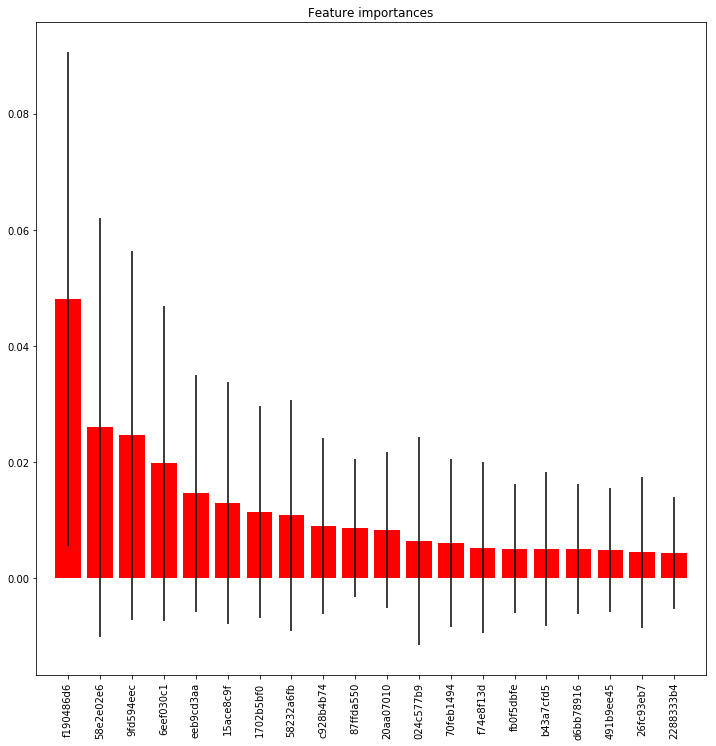

In [8]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plot the importances ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [35]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 63,
        #'min_data_in_leaf': 100,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.1,
        "bagging_frequency" : 1,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.20447	valid_1's rmse: 1.42391
[400]	training's rmse: 0.985838	valid_1's rmse: 1.39199
Early stopping, best iteration is:
[473]	training's rmse: 0.930987	valid_1's rmse: 1.39024
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.20295	valid_1's rmse: 1.42812
[400]	training's rmse: 0.984461	valid_1's rmse: 1.38077
[600]	training's rmse: 0.850552	valid_1's rmse: 1.3742
Early stopping, best iteration is:
[618]	training's rmse: 0.840818	valid_1's rmse: 1.37361
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.20269	valid_1's rmse: 1.42802
[400]	training's rmse: 0.985789	valid_1's rmse: 1.39376
[600]	training's rmse: 0.854595	valid_1's rmse: 1.38858
Early stopping, best iteration is:
[610]	training's rmse: 0.849262	valid_1's rmse: 1.38853
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.20002	

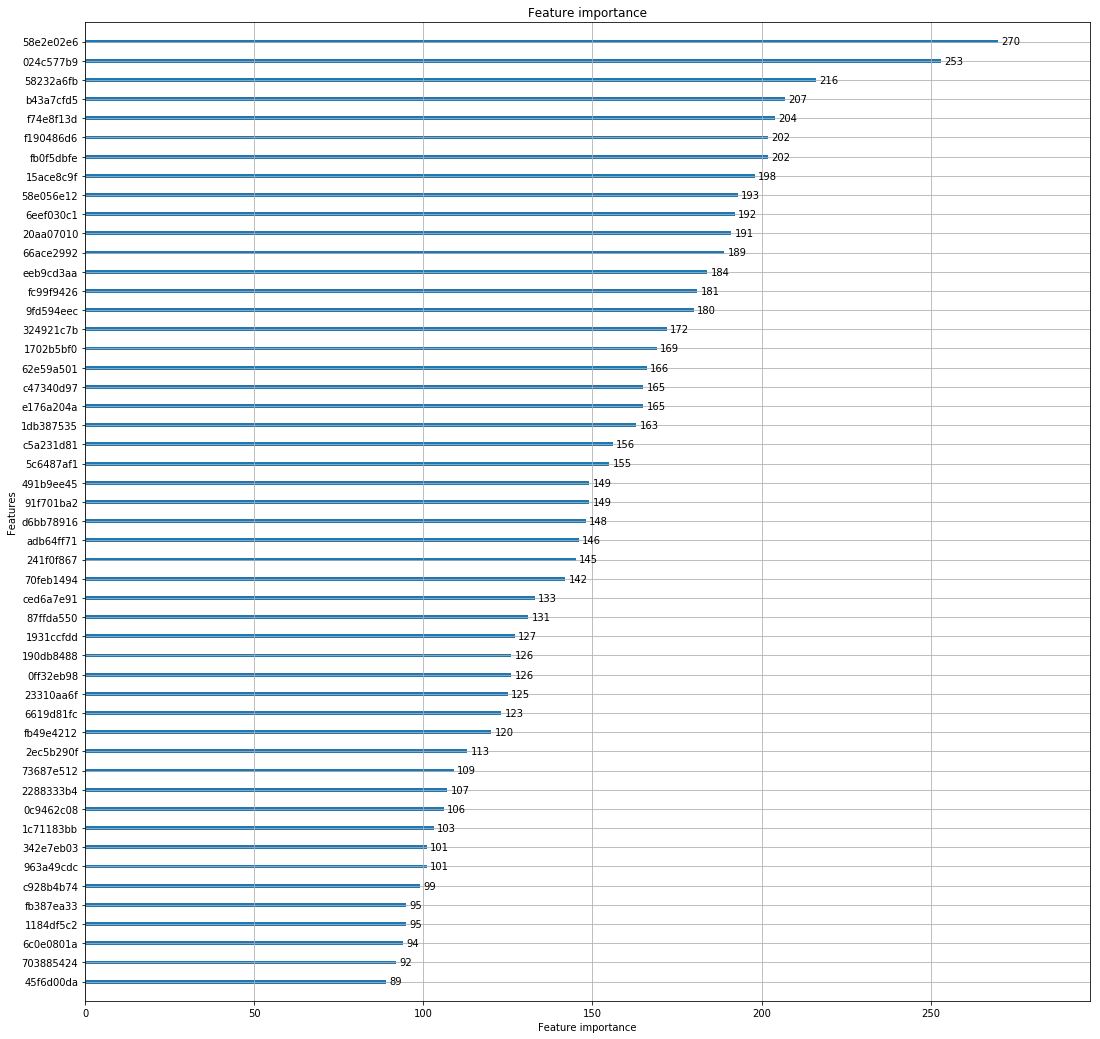

In [37]:

lgb.plot_importance(model, max_num_features=50, figsize=(18, 18))

In [38]:
# Making a submission file #
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("baseline_lgb.csv", index=False)

In [39]:
train_df.head()

ID      target  48df886f9  0deb4b6a8  34b15f335  a8cb14b00  \
0  000d6aaf2  38000000.0        0.0          0        0.0          0   
1  000fbd867    600000.0        0.0          0        0.0          0   
2  0027d6b71  10000000.0        0.0          0        0.0          0   
3  0028cbf45   2000000.0        0.0          0        0.0          0   
4  002a68644  14400000.0        0.0          0        0.0          0   

   2f0771a37  30347e683  d08d1fbe3  6ee66e115  20aa07010  dc5a8f1d8  \
0          0          0          0          0        0.0        0.0   
1          0          0          0          0  2200000.0        0.0   
2          0          0          0          0        0.0        0.0   
3          0          0          0          0        0.0        0.0   
4          0          0          0          0  2000000.0        0.0   

   11d86fa6a  77c9823f2  8d6c2a0b2  4681de4fd  adf119b9a  cff75dd09  \
0        0.0          0          0          0          0        0.0   
1        0.0          0          0          0          0        0.0   
2        0.0          0          0          0          0        0.0   
3        0.0          0          0          0          0        0.0   
4        0.0          0          0          0          0        0.0   

   96f83a237  b8a716ebf  6c7a4567c  4fcfd2b4d  f3b9c0b95  71cebf11c  \
0          0        0.0          0          0        0.0          0   
1          0        0.0          0          0        0.0          0   
2          0        0.0          0          0        0.0          0   
3          0        0.0          0          0        0.0          0   
4          0        0.0          0          0        0.0          0   

   d966ac62c  68b647452  c88d108c9  ff7b471cd  d5308d8bc  0d866c3d7  \
0          0        0.0          0          0          0        0.0   
1          0        0.0          0          0          0        0.0   
2          0        0.0          0          0          0        0.0   
3          0        0.0          0          0          0        0.0   
4          0        0.0          0          0          0        0.0   

   bc3f77679  bd8f989f1  0eff5bf95  22ed6dba3  92b13ebba  c330f1a67  \
0          0        0.0          0        0.0        0.0          0   
1          0        0.0          0        0.0        0.0          0   
2          0        0.0          0        0.0        0.0          0   
3          0        0.0          0        0.0        0.0          0   
4          0        0.0          0        0.0        0.0          0   

   233c7c17c  2cb4d123e  eeac16933  87ffda550  822e49b95  316b978cd  \
0        0.0          0          0  1300000.0        0.0          0   
1        0.0          0          0        0.0        0.0          0   
2        0.0          0          0        0.0        0.0          0   
3        0.0          0          0        0.0        0.0          0   
4        0.0          0          0        0.0        0.0          0   

   d04e16aed  5d5c5ce6d  ec863cb52  11ad148bd  ea18d720e  408d86ce9  \
0        0.0          0          0        0.0        0.0        0.0   
1        0.0          0          0        0.0        0.0        0.0   
2        0.0          0          0        0.0        0.0        0.0   
3        0.0          0          0        0.0        0.0        0.0   
4        0.0          0          0        0.0        0.0        0.0   

   69d8b4020  b0868a049  80b14398e  ecdef52b2  c36bcacc5  151d318cd  \
0          0          0        0.0        0.0          0          0   
1          0          0        0.0        0.0          0          0   
2          0          0        0.0        0.0          0          0   
3          0          0        0.0        0.0          0          0   
4          0          0        0.0        0.0          0          0   

   ab0cddb90  2d6bd8275   dfdf4b580  c87722678  a8c320153  7df8788e8  \
0          0        0.0         0.0          0          0          0   
1          0     